# DOG & CAT Detection

In [1]:
#plt.style.use('ggplot')
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
print(os.listdir("./cat-and-dog-4000/"))

['.DS_Store', 'test_set.zip', 'training_set', 'training_set.zip', 'test_set']


In [3]:
!pip install tqdm

     |████████████████████████████████| 51kB 383kB/s eta 0:00:011
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 
from random import randint
from sklearn.utils import shuffle
from tqdm import tqdm #Progress Bars
from PIL import Image

In [4]:
train_path = "./cat-and-dog-4000/training_set/"
test_path = "./cat-and-dog-4000/test_set/"

img_height = 200
img_width = 200
img_size = 200

### Crop images

In [5]:
def resize_image(image):
    height, width = image.shape
    cropped = image
    if height < width:
        diff = (width - height) // 2
        cropped = image[:, diff: (diff + height)]
    elif height > width:
        diff = (height - width) // 2
        cropped = image[diff: (diff + width), :]

    height, width = cropped.shape
    if height > img_size:    # shrink image
        return cv2.resize(cropped, (img_size, img_size), interpolation=cv2.INTER_AREA)
    elif height < img_size:  # enlarge image
        return cv2.resize(cropped, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
    else:
        return cropped

### Load images

In [6]:
def get_images(train_path):
    Images = []
    Labels = []  # 0 for Building , 1 dog, 2 for cat
    Filenames = []
    label = 0
        
    for labels in os.listdir(train_path): #Main Directory where each class label is present as folder name.
        if "DS_Store" in labels:
            continue
        
        if labels == 'cats': #Folder contain Cat Images get the '0' class label.
            label = 0
            count = 0;
        elif labels == 'dogs':
            label = 1
            count = 0;
        
        for image_file in tqdm(os.listdir(train_path + labels)): #Extracting the file name of the image from Class Label folder
            if ".jpg" not in image_file:
                continue
            count += 1;
            path = train_path + labels +r'/' + image_file
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE) #Reading the image (OpenCV)
            image = cv2.adaptiveThreshold(image,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
            image = resize_image(image) #Resizing is very Important
            if count <= 4000:
                Images.append(image)
                Labels.append(label)
                Filenames.append(path)
    
    return shuffle(Images, Labels, Filenames, random_state=817328462) #Shuffle the dataset you just prepared.


### Train set and labels

In [7]:
train_images, train_labels, train_filenames = get_images('./cat-and-dog-4000/training_set/') #Extract the training images from the folders.

x_train = np.asarray(train_images) #converting the list of images to numpy array.
y_train = np.asarray(train_labels)

100%|██████████| 4001/4001 [00:48<00:00, 82.54it/s] 


In [8]:
x_train = x_train/255.0
x_train.shape

(8000, 200, 200)

In [9]:
y_train = y_train.reshape(x_train.shape[0], 1)
y_train.shape

(8000, 1)

In [18]:
train_images[7]

array([[255, 255, 255, ..., 255, 210,   0],
       [255, 255, 255, ..., 255, 210,   0],
       [255, 255, 255, ..., 246, 210,   0],
       ..., 
       [246, 255, 161, ..., 103,  29, 165],
       [255, 244, 198, ..., 199, 195, 195],
       [255, 107,   0, ..., 255, 255, 255]], dtype=uint8)

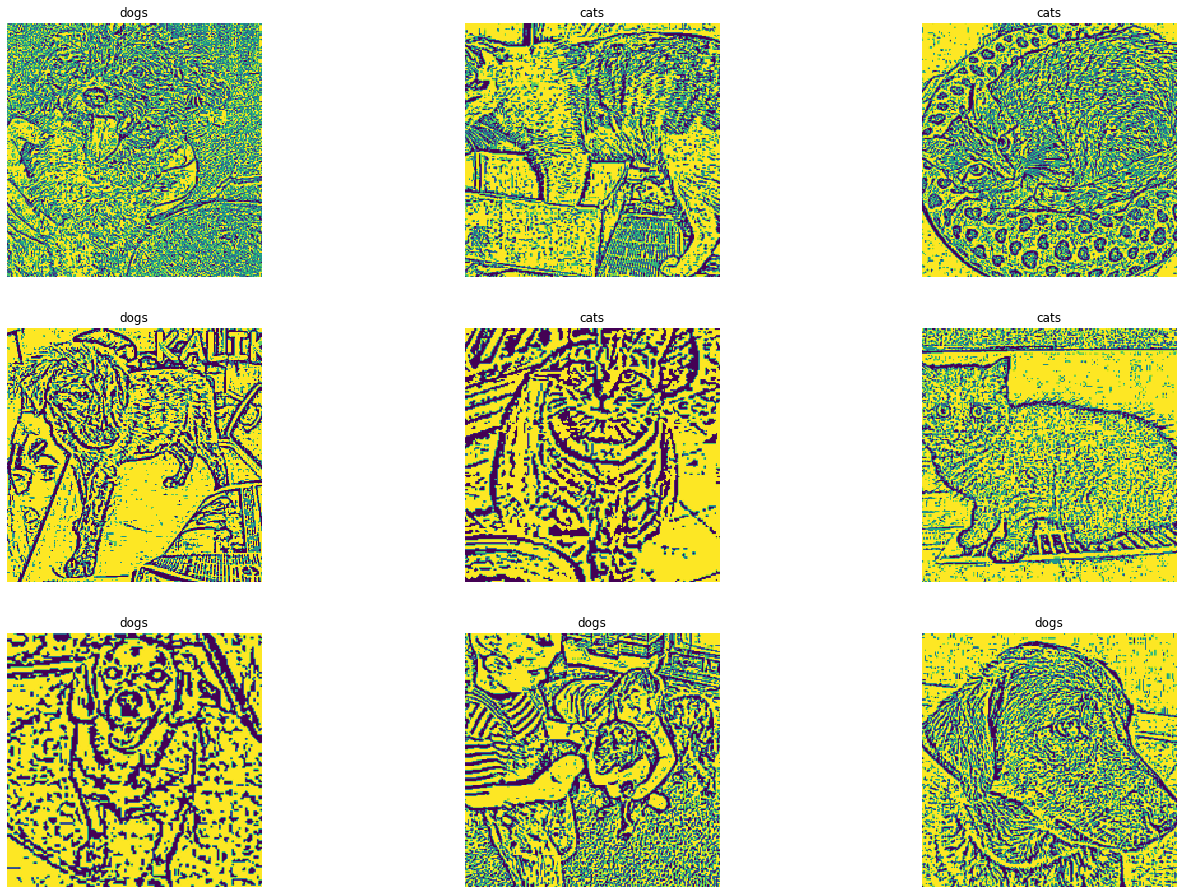

In [10]:
def get_classlabel(class_code):
    labels = {0:'cats', 1:'dogs'}
    
    return labels[class_code]

f, ax = plt.subplots(3,3) 
f.subplots_adjust(0,0,3,3)
for i in range(0,3,1):
    for j in range(0,3,1):
        rnd_number = randint(0, len(train_images)-1)
        ax[i,j].imshow(train_images[rnd_number])
        ax[i,j].set_title(get_classlabel(train_labels[rnd_number]))
        ax[i,j].axis('off')

In [11]:
number_of_train = x_train.shape[0]

In [12]:
x_train_flatten = x_train.reshape(number_of_train, x_train.shape[1]*x_train.shape[2])

print("X train flatten", x_train_flatten.shape)

X train flatten (8000, 40000)


In [13]:
#transpose
x_train = x_train_flatten.T #Same as self.transpose(), except that self is returned if self.ndim < 2
y_train = y_train.T

print("x train: ", x_train.shape)
print("y train: ", y_train.shape)

x train:  (40000, 8000)
y train:  (1, 8000)


## TRAIN WITH LOGISTIC REGRESSION

In [14]:
def init_weights_and_bias(dimension):
    weight = np.full((dimension, 1), 0.01)
    bias = 0.0
    return weight, bias

In [15]:
def sigmoid(z):
    y_head = 1/(1+np.exp(-z)) #1/(1+e^-x)
    return y_head

In [16]:
def forward_backward_propagation(weight, bias, x_train, y_train):
    # forward propagation
    z = np.dot(weight.T, x_train) + bias
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head) #-(y^)*log(ŷhat)-(1-y)*log(1-ŷhat)
    cost = (np.sum(loss))/x_train.shape[1] #x_train.shape[1]  is for scaling
    
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1] 
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost, gradients

In [17]:
def update_weight(weight, bias, x_train, y_train, learning_rate, number_of_iterarion, is_train):
    cost_list = []
    cost_list_plt = []
    index = []
    
    for i in range(number_of_iterarion):
        
        cost, gradients = forward_backward_propagation(weight, bias, x_train, y_train)
        cost_list.append(cost)
        
        weight = weight - learning_rate * gradients["derivative_weight"]
        bias = bias - learning_rate * gradients["derivative_bias"]
        
        if is_train and i > 0 and i % 2000 == 0:
            cost_list_plt.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %.4f" %(i, cost))
                
    parameters = {"weight": weight, "bias": bias}
    
    if is_train:
        plt.plot(index, cost_list_plt)
        plt.xticks(index, rotation='vertical')
        plt.xlabel("Number of Iterarion")
        plt.ylabel("Cost")
        plt.show()
        
    return parameters, gradients, cost_list

In [18]:
def predict(weight, bias, x_test):
    
    z = sigmoid(np.dot(weight.T, x_test) + bias)
    Y_prediction = np.zeros((1, x_test.shape[1]))

    for i in range(z.shape[1]):
        if z[0, i] <= 0.5:
            Y_prediction[0, i] = 0 #Cat
        else:
            Y_prediction[0, i] = 1 #Dog

    return Y_prediction

In [19]:
def logistic_regression(x_train, y_train, learning_rate, num_iterations, is_train):

    dimension =  x_train.shape[0]
    weight, bias = init_weights_and_bias(dimension)

    parameters, gradients, cost_list = update_weight(weight, bias, x_train, y_train, learning_rate, num_iterations, is_train)
    
    y_prediction_train = predict(parameters["weight"], parameters["bias"], x_train)
    
    print("Train Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100, 2)))
    
    return y_prediction_train

Cost after iteration 2000: 1.2476
Cost after iteration 4000: 0.9907
Cost after iteration 6000: 0.7473
Cost after iteration 8000: 0.4994
Cost after iteration 10000: 0.2124
Cost after iteration 12000: 0.1845
Cost after iteration 14000: 0.1673
Cost after iteration 16000: 0.1530
Cost after iteration 18000: 0.1410
Cost after iteration 20000: 0.1306
Cost after iteration 22000: 0.1216
Cost after iteration 24000: 0.1137
Cost after iteration 26000: 0.1067
Cost after iteration 28000: 0.1004
Cost after iteration 30000: 0.0949
Cost after iteration 32000: 0.0899
Cost after iteration 34000: 0.0853
Cost after iteration 36000: 0.0812
Cost after iteration 38000: 0.0775
Cost after iteration 40000: 0.0740
Cost after iteration 42000: 0.0709
Cost after iteration 44000: 0.0680
Cost after iteration 46000: 0.0653
Cost after iteration 48000: 0.0628
Cost after iteration 50000: 0.0605
Cost after iteration 52000: 0.0583
Cost after iteration 54000: 0.0563
Cost after iteration 56000: 0.0544
Cost after iteration 580

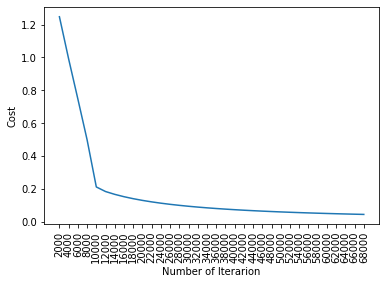

Train Accuracy: 100.0 %


In [20]:
train_result = logistic_regression(x_train, y_train, learning_rate=0.0009, num_iterations=70000, is_train=True)

## Test with another data

In [21]:
test_images, test_labels, test_filenames = get_images('./cat-and-dog-4000/test_set/')

100%|██████████| 1012/1012 [00:12<00:00, 83.31it/s]


In [22]:
x_test = np.asarray(test_images)
y_test = np.asarray(test_labels)

In [23]:
x_test = x_test/255.0

In [24]:
y_test = y_test.reshape(x_test.shape[0], 1)

In [25]:
number_test = x_test.shape[0]
x_flatten_test = x_test.reshape(number_test, x_test.shape[1]*x_test.shape[2])

x_test = x_flatten_test.T
y_test = y_test.T

In [26]:
def test_logistic_regression(x_test, y_test, learning_rate, num_iterations, is_train):

    dimension =  x_train.shape[0]
    weight, bias = init_weights_and_bias(dimension)

    parameters, gradients, cost_list = update_weight(weight, bias, x_test, y_test, learning_rate, num_iterations, is_train)
    
    y_prediction_test = predict(parameters["weight"], parameters["bias"], x_test)
    
    print("Test Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100, 2)))
    
    return y_prediction_test

In [27]:
test_result = test_logistic_regression(x_test, y_test, learning_rate=0.0009, num_iterations=20000, is_train=False)

Test Accuracy: 100.0 %


In [28]:
number_show = 50

df_filenames = test_filenames[:number_show]
df_labels = test_labels[:number_show]
df_result = test_result[0][:number_show]

data_frame = pd.DataFrame({
    'filename': df_filenames,
    'label': df_labels,
    'predict': df_result
})

data_frame

filename  label  predict
0   ./cat-and-dog-4000/test_set/cats/cat.4936.jpg      0      0.0
1   ./cat-and-dog-4000/test_set/cats/cat.4168.jpg      0      0.0
2   ./cat-and-dog-4000/test_set/cats/cat.4824.jpg      0      0.0
3   ./cat-and-dog-4000/test_set/dogs/dog.4226.jpg      1      1.0
4   ./cat-and-dog-4000/test_set/dogs/dog.4664.jpg      1      1.0
5   ./cat-and-dog-4000/test_set/dogs/dog.4209.jpg      1      1.0
6   ./cat-and-dog-4000/test_set/cats/cat.4596.jpg      0      0.0
7   ./cat-and-dog-4000/test_set/cats/cat.4970.jpg      0      0.0
8   ./cat-and-dog-4000/test_set/cats/cat.4896.jpg      0      0.0
9   ./cat-and-dog-4000/test_set/dogs/dog.4980.jpg      1      1.0
10  ./cat-and-dog-4000/test_set/cats/cat.4229.jpg      0      0.0
11  ./cat-and-dog-4000/test_set/cats/cat.4604.jpg      0      0.0
12  ./cat-and-dog-4000/test_set/cats/cat.4775.jpg      0      0.0
13  ./cat-and-dog-4000/test_set/cats/cat.4012.jpg      0      0.0
14  ./cat-and-dog-4000/test_set/cats/cat.4799.jpg      0      0.0
15  ./cat-and-dog-4000/test_set/cats/cat.4192.jpg      0      0.0
16  ./cat-and-dog-4000/test_set/cats/cat.4082.jpg      0      0.0
17  ./cat-and-dog-4000/test_set/cats/cat.4203.jpg      0      0.0
18  ./cat-and-dog-4000/test_set/dogs/dog.4260.jpg      1      1.0
19  ./cat-and-dog-4000/test_set/cats/cat.4605.jpg      0      0.0
20  ./cat-and-dog-4000/test_set/dogs/dog.4038.jpg      1      1.0
21  ./cat-and-dog-4000/test_set/cats/cat.4788.jpg      0      0.0
22  ./cat-and-dog-4000/test_set/cats/cat.4216.jpg      0      0.0
23  ./cat-and-dog-4000/test_set/cats/cat.4269.jpg      0      0.0
24  ./cat-and-dog-4000/test_set/dogs/dog.4742.jpg      1      1.0
25  ./cat-and-dog-4000/test_set/cats/cat.4822.jpg      0      0.0
26  ./cat-and-dog-4000/test_set/cats/cat.4954.jpg      0      0.0
27  ./cat-and-dog-4000/test_set/cats/cat.4364.jpg      0      0.0
28  ./cat-and-dog-4000/test_set/cats/cat.4565.jpg      0      0.0
29  ./cat-and-dog-4000/test_set/cats/cat.4525.jpg      0      0.0
30  ./cat-and-dog-4000/test_set/dogs/dog.4921.jpg      1      1.0
31  ./cat-and-dog-4000/test_set/dogs/dog.4848.jpg      1      1.0
32  ./cat-and-dog-4000/test_set/dogs/dog.4951.jpg      1      1.0
33  ./cat-and-dog-4000/test_set/cats/cat.4768.jpg      0      0.0
34  ./cat-and-dog-4000/test_set/dogs/dog.4406.jpg      1      1.0
35  ./cat-and-dog-4000/test_set/dogs/dog.4862.jpg      1      1.0
36  ./cat-and-dog-4000/test_set/dogs/dog.4218.jpg      1      1.0
37  ./cat-and-dog-4000/test_set/cats/cat.4534.jpg      0      0.0
38  ./cat-and-dog-4000/test_set/dogs/dog.4630.jpg      1      1.0
39  ./cat-and-dog-4000/test_set/cats/cat.4582.jpg      0      0.0
40  ./cat-and-dog-4000/test_set/dogs/dog.4447.jpg      1      1.0
41  ./cat-and-dog-4000/test_set/dogs/dog.4352.jpg      1      1.0
42  ./cat-and-dog-4000/test_set/dogs/dog.4198.jpg      1      1.0
43  ./cat-and-dog-4000/test_set/cats/cat.4442.jpg      0      0.0
44  ./cat-and-dog-4000/test_set/cats/cat.4729.jpg      0      0.0
45  ./cat-and-dog-4000/test_set/dogs/dog.4393.jpg      1      1.0
46  ./cat-and-dog-4000/test_set/dogs/dog.4079.jpg      1      1.0
47  ./cat-and-dog-4000/test_set/dogs/dog.4690.jpg      1      1.0
48  ./cat-and-dog-4000/test_set/dogs/dog.4642.jpg      1      1.0
49  ./cat-and-dog-4000/test_set/dogs/dog.4061.jpg      1      1.0

In [29]:
from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

#dictionary to name the prediction
predict_target = {0: 'CAT', 1: 'DOG'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    
def display_HTML(filename, prediction):
    target = 'DOG'        
    if prediction <= 0.5:
        target = 'CAT'
            
    html = '''
        <div style="overflow: auto;  border: 2px solid #D8D8D8;
            padding: 5px; width: 420px;" >
            <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
            <div style="padding: 10px 0px 0px 20px; overflow: auto;">
                <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
                <p style="margin-left: 50px; margin-top: 0px; font-size: 12px">Filename: {}</p>
            </div>
        </div>
        '''.format(img_to_display(filename), target, filename.split('/')[-1])

    display(HTML(html))

./cat-and-dog-4000/test_set/cats/cat.4433.jpg



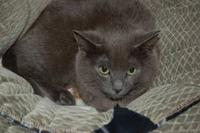

./cat-and-dog-4000/test_set/dogs/dog.4603(1).jpg



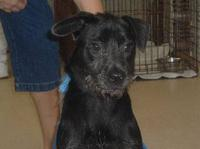

./cat-and-dog-4000/test_set/dogs/dog.4171.jpg



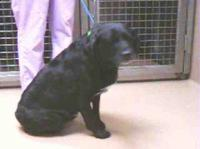

./cat-and-dog-4000/test_set/dogs/dog.4617.jpg



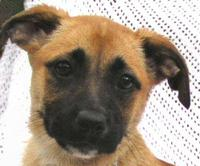

./cat-and-dog-4000/test_set/dogs/dog.4159.jpg



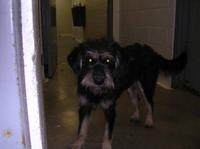

./cat-and-dog-4000/test_set/cats/cat.4369.jpg



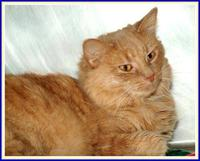

./cat-and-dog-4000/test_set/cats/cat.4355.jpg



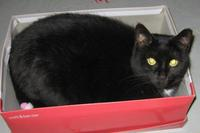

./cat-and-dog-4000/test_set/cats/cat.4427.jpg



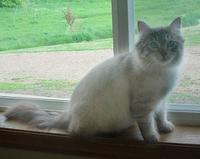

In [39]:
for index, row in data_frame.iterrows():
    print(row['filename'])
    display_HTML(row['filename'], row['predict'])

In [30]:
print(x_train)

[[ 0.57647059  0.46666667  0.75294118 ...,  0.          1.          0.        ]
 [ 0.78039216  0.6         0.46666667 ...,  0.          1.          0.50196078]
 [ 0.81960784  0.58039216  0.9254902  ...,  0.32941176  1.          0.97254902]
 ..., 
 [ 0.          0.13333333  1.         ...,  1.          0.19607843  0.        ]
 [ 0.06666667  0.72156863  1.         ...,  1.          0.05882353
   0.44705882]
 [ 0.42352941  0.24705882  1.         ...,  1.          0.93333333  1.        ]]
